# XPCS Pipeline for SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [1]:
if False:
    from chxanalys.chx_libs import (np, roi, time, datetime, os, get_events, 
                                getpass, db, get_images,LogNorm, plt,tqdm, utils, Model,
                               multi_tau_lags)

    from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,  
     load_data, load_mask,get_fields, reverse_updown, ring_edges,get_avg_img,check_shutter_open,
    apply_mask, show_img,check_ROI_intensity,run_time, plot1D, get_each_frame_intensity,                                             
    create_hot_pixel_mask,show_ROI_on_image,create_time_slice,save_lists, 
                        save_arrays, psave_obj,pload_obj, get_non_uniform_edges )
 

    from chxanalys.XPCS_SAXS import (get_circular_average,save_lists,get_ring_mask, get_each_ring_mean_intensity,
                                 plot_qIq_with_ROI,save_saxs_g2,plot_saxs_g2,fit_saxs_g2,cal_g2,
                                create_hot_pixel_mask,get_circular_average,get_t_iq,save_saxs_g2,
                                plot_saxs_g2,fit_saxs_g2,fit_q2_rate,plot_saxs_two_g2,fit_q_rate,
                                circular_average,plot_saxs_g4, get_t_iqc,multi_uids_saxs_xpcs_analysis,
                                 save_g2)


    from chxanalys.Two_Time_Correlation_Function import (show_C12, get_one_time_from_two_time,
                                                get_four_time_from_two_time,rotate_g12q_to_rectangle)
    from chxanalys.chx_compress import (combine_binary_files,
                           segment_compress_eigerdata,     create_compress_header,            
                            para_segment_compress_eigerdata,para_compress_eigerdata)

    from chxanalys.chx_compress_analysis import ( compress_eigerdata, read_compressed_eigerdata,
                                             Multifile,get_avg_imgc, get_each_frame_intensityc,
                get_each_ring_mean_intensityc, mean_intensityc,cal_waterfallc,plot_waterfallc,  
)

    from chxanalys.SAXS import fit_form_factor
    from chxanalys.chx_correlationc import ( cal_g2c,Get_Pixel_Arrayc,auto_two_Arrayc,get_pixelist_interp_iq,)
    from chxanalys.chx_correlationp import (cal_g2p, auto_two_Arrayp)

    from chxanalys.Create_Report import (create_pdf_report, 
                                create_multi_pdf_reports_for_uids,create_one_pdf_reports_for_uids)


    from chxanalys.XPCS_GiSAXS import (get_qedge,get_qmap_label,get_qr_tick_label, get_reflected_angles,
    convert_gisaxs_pixel_to_q, show_qzr_map, get_1d_qr, get_qzrmap, show_qzr_roi,get_each_box_mean_intensity,
    save_gisaxs_g2,plot_gisaxs_g2, fit_gisaxs_g2,plot_gisaxs_two_g2,plot_qr_1d_with_ROI,fit_qr_qz_rate,
                                  multi_uids_gisaxs_xpcs_analysis,plot_gisaxs_g4,
                                  get_t_qrc, plot_t_qrc)

    %matplotlib notebook

In [3]:

if True:
    from chxanalys_debug.chx_libs import (np, roi, time, datetime, os, get_events, 
                                getpass, db, get_images,LogNorm, plt,tqdm, utils, Model,
                               multi_tau_lags)

    from chxanalys_debug.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,  
     load_data, load_mask,get_fields, reverse_updown, ring_edges,get_avg_img,check_shutter_open,
    apply_mask, show_img,check_ROI_intensity,run_time, plot1D, get_each_frame_intensity,                                             
    create_hot_pixel_mask,show_ROI_on_image,create_time_slice,save_lists, 
                        save_arrays, psave_obj,pload_obj, get_non_uniform_edges )
 

    from chxanalys_debug.XPCS_SAXS import (get_circular_average,save_lists,get_ring_mask, get_each_ring_mean_intensity,
                                 plot_qIq_with_ROI,save_saxs_g2,plot_saxs_g2,fit_saxs_g2,cal_g2,
                                create_hot_pixel_mask,get_circular_average,get_t_iq,save_saxs_g2,
                                plot_saxs_g2,fit_saxs_g2,fit_q2_rate,plot_saxs_two_g2,fit_q_rate,
                                circular_average,plot_saxs_g4, get_t_iqc,multi_uids_saxs_xpcs_analysis,
                                 get_angular_mask,save_g2,plot_g2,get_g2_fit,
                                    get_ring_anglar_mask,save_seg_saxs_g2,plot_saxs_rad_ang_g2,
                                    fit_saxs_rad_ang_g2,
                                multi_uids_saxs_flow_xpcs_analysis,save_g2_fit_para_tocsv)  



    from chxanalys_debug.Two_Time_Correlation_Function import (show_C12, get_one_time_from_two_time,
                                                get_four_time_from_two_time,rotate_g12q_to_rectangle)
    from chxanalys_debug.chx_compress_debug import (combine_binary_files,
                           segment_compress_eigerdata,     create_compress_header,            
                            para_segment_compress_eigerdata,para_compress_eigerdata)

    from chxanalys_debug.chx_compress_analysis import ( compress_eigerdata, read_compressed_eigerdata,
                                             Multifile,get_avg_imgc, get_each_frame_intensityc,
                get_each_ring_mean_intensityc, mean_intensityc,cal_waterfallc,plot_waterfallc,  
)

    from chxanalys_debug.SAXS import fit_form_factor
    from chxanalys_debug.chx_correlationc import ( cal_g2c,Get_Pixel_Arrayc,auto_two_Arrayc,get_pixelist_interp_iq,)
    from chxanalys_debug.chx_correlationp import (cal_g2p, auto_two_Arrayp)

    from chxanalys_debug.Create_Report import (create_pdf_report, 
                                create_multi_pdf_reports_for_uids,create_one_pdf_reports_for_uids)


    from chxanalys_debug.XPCS_GiSAXS import (get_qedge,get_qmap_label,get_qr_tick_label, get_reflected_angles,
    convert_gisaxs_pixel_to_q, show_qzr_map, get_1d_qr, get_qzrmap, show_qzr_roi,get_each_box_mean_intensity,
    save_gisaxs_g2,plot_gisaxs_g2, fit_gisaxs_g2,plot_gisaxs_two_g2,plot_qr_1d_with_ROI,fit_qr_qz_rate,
                                  multi_uids_gisaxs_xpcs_analysis,plot_gisaxs_g4,
                                  get_t_qrc, plot_t_qrc)
    
    import sys
    import pandas as pds

    %matplotlib notebook

In [4]:
plt.rcParams.update({'figure.max_open_warning': 0})

In [5]:
#%%javascript
#var nb = IPython.notebook;
#var kernel = IPython.notebook.kernel;
#var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
#kernel.execute(command);

In [6]:
#print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

## Make a directory for saving results

In [7]:
CYCLE = '2016_3'
username = getpass.getuser()
username = "colosqui"

date_path = datetime.now().strftime('%Y/%m/%d')  # e.g., '2016/03/01'
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/colosqui/Results/


## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines to get data

In [8]:

start_time, stop_time = '2016-12-3  18:51:00', '2016-12-3  19:13:00'  


hdrs = db(start_time= start_time, stop_time = stop_time)
print ('Totally %s uids are found'%(len(hdrs)))
sids=[]
uids=[]

for hdr in hdrs:
    s= get_sid_filenames( hdr)
    print (s)
    sids.append( s[0] )
    uids.append( s[1] )
sids=sids[::-1]
uids=uids[::-1]

uid = uids[0]

Totally 5 uids are found
(11072, '667327b7-4661-4e5b-9421-ae5d00723086', ['/XF11ID/data/2016/12/03/45e9c951-ab3d-439d-a51d_3841'])
(11071, '57c3362b-175c-4aea-a42e-d25d21c88dd1', ['/XF11ID/data/2016/12/03/479a024e-50fb-403d-8b22_3840'])
(11070, '073f83ac-055f-49f5-ad36-3e0e5d5589d0', ['/XF11ID/data/2016/12/03/3c1336a4-9902-4525-9e32_3839'])
(11069, 'dd781ed5-2c32-44c2-9782-bb07e6f293fa', ['/XF11ID/data/2016/12/03/020ccaf1-6618-4d11-8ede_3838'])
(11068, '99aaa04f-a6af-4ca0-9e5b-1c9e2704d6be', ['/XF11ID/data/2016/12/03/fc90f137-fbf4-4a3a-a58a_3837'])


In [9]:
uid_=  'S3U2_Flow40_pos_0.1' #give a meaningful folder name

#S3 in capillary 250 frames 1.3ms/20ms 


data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/%s/'%uid_)

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/


In [10]:
data_dir_ = os.path.join( data_dir, 'Average/')
os.makedirs(data_dir_, exist_ok=True)
print ( data_dir_)

/XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/Average/


# Don't Change these lines below here

In [11]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  11068--99aaa04f-a6af-4ca0-9e5b-1c9e2704d6be--/XF11ID/data/2016/12/03/fc90f137-fbf4-4a3a-a58a_3837


In [12]:
imgs = load_data( uid, detector, reverse= True  )
Nimg = len(imgs)
md = imgs.md

hdf5 path = /XF11ID/data/2016/12/03/fc90f137-fbf4-4a3a-a58a_3837_master.h5


In [13]:
try:
    md['Measurement']= db[uid]['start']['Measurement']
    md['sample']=db[uid]['start']['sample']     
    m#d['sample']= 'PS205000-PMMA-207000-SMMA3'
    print( md['sample'])
    
except:
    md['Measurement']= 'Measurement'
    md['sample']='sample'

In [14]:
imgs

Sliced and/or processed FixedEigerImages. Original repr:
    <Frames>
    Length: 1000 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16

## Overwrite Some Metadata Due to Wrong Input

In [15]:
md

{'Measurement': 'Measurement',
 'beam_center_x': 1443.0,
 'beam_center_y': 816.0,
 'count_time': 0.00133,
 'detector_distance': 4.8899999,
 'frame_time': 0.00134,
 'incident_wavelength': 1.2848103,
 'pixel_mask': array([[0, 0, 0, ..., 0, 0, 4],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint32),
 'sample': 'sample',
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [16]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms

Ldet = 4.84 * 1000          # detector to sample distance (mm), currently, *1000 for saxs, *1 for gisaxs

exposuretime= md['count_time']
acquisition_period = md['frame_time']
print( 'The sample is %s'%(  md['sample']  ))
print( 'Exposuretime=%s sec, Acquisition_period=%s sec'%( exposuretime, acquisition_period  ))
timeperframe = acquisition_period#for g2
#timeperframe = exposuretime#for visiblitly
#timeperframe = 2  ## manual overwrite!!!! we apparently writing the wrong metadata....

center = [  md['beam_center_x'],md['beam_center_y']  ]   #for 4M

center=[center[1], center[0]]
print ('Beam center=', center)




The sample is sample
Exposuretime=0.00133 sec, Acquisition_period=0.00134 sec
Beam center= [816.0, 1443.0]


In [17]:
setup_pargs=dict(uid=uid_, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
        timeperframe=timeperframe, center=center, path= data_dir_, md=md)

In [18]:
setup_pargs

{'Ldet': 4840.0,
 'center': [816.0, 1443.0],
 'dpix': 0.075000003562308848,
 'lambda_': 1.2848103,
 'md': {'Measurement': 'Measurement',
  'beam_center_x': 1443.0,
  'beam_center_y': 816.0,
  'count_time': 0.00133,
  'detector_distance': 4.8899999,
  'frame_time': 0.00134,
  'incident_wavelength': 1.2848103,
  'pixel_mask': array([[0, 0, 0, ..., 0, 0, 4],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ..., 
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint32),
  'sample': 'sample',
  'x_pixel_size': 7.5000004e-05,
  'y_pixel_size': 7.5000004e-05},
 'path': '/XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/Average/',
 'timeperframe': 0.00134,
 'uid': 'S3U2_Flow40_pos_0.1'}

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [19]:
mask_path = '/XF11ID/analysis/2016_3/masks/'
mask_name = 'Dec3_4M_SAXS_mask.npy'

<IPython.core.display.Javascript object>


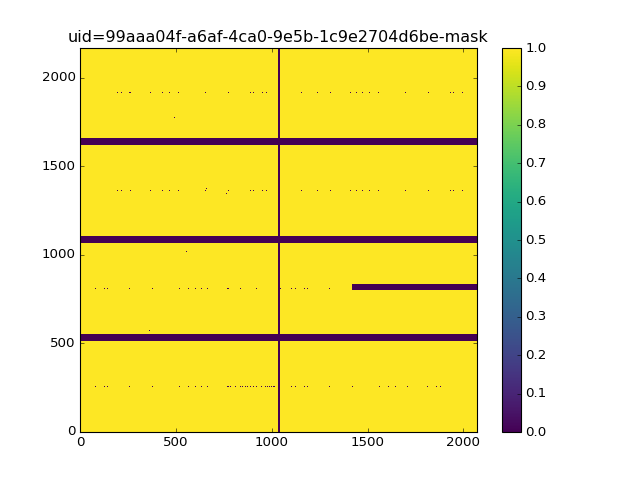

In [20]:
mask = load_mask(mask_path, mask_name, plot_ =  True, image_name = 'uid=%s-mask'%uid, reverse=True ) 
#show_img(mask)
mask_load=mask.copy()

# Save metadata into the uid folder
* save mask file
* save the metadata dict

In [21]:
md['mask'] = mask
md['mask_file']= mask_path + mask_name 
md['NOTEBOOK_FULL_PATH'] = None #NOTEBOOK_FULL_PATH
#psave_obj(  md, data_dir + 'uid=%s-md'%uid ) #save the setup parameters
#md = pload_obj(data_dir + 'uid=%s-md'%uid  )

In [22]:
imgsa = apply_mask( imgs, mask )

<IPython.core.display.Javascript object>


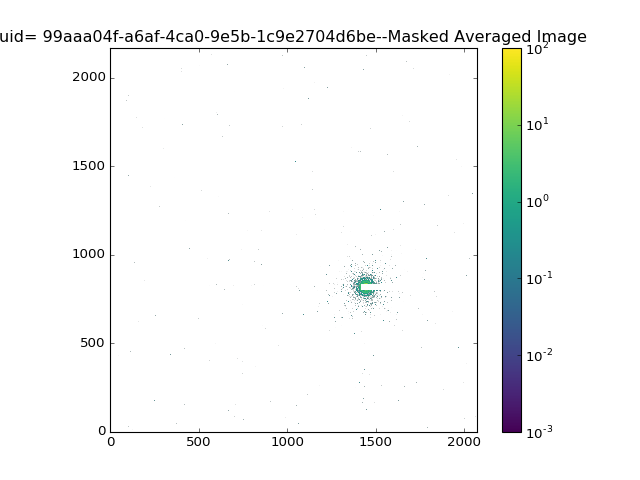

In [23]:
avg_img =  get_avg_img( imgsa, sampling = int(Nimg/3), plot_ = True, uid =uid)

<IPython.core.display.Javascript object>


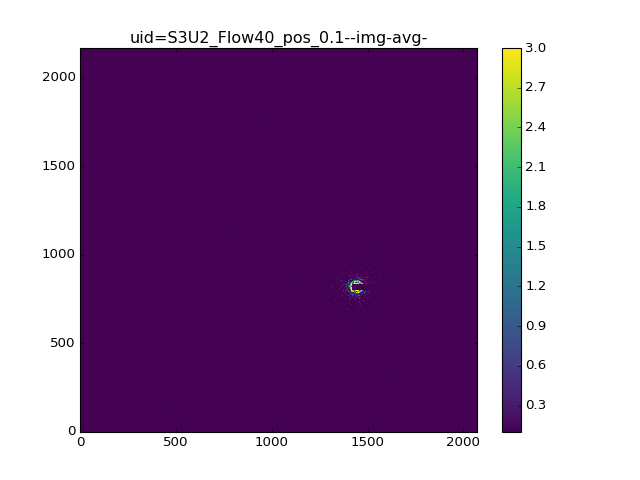

In [24]:
#avg_img = get_avg_imgc( FD,  beg=0,end=10000,sampling = 1, plot_ = False )
show_img( avg_img,  vmin=.1, vmax=3.0, logs=False, image_name= 'uid=%s--img-avg-'%uid_,
        save=True, path=data_dir_) 
md['avg_img'] = avg_img

# Suppose we have all the parameters to define ROIs, if not use the "Single_Data" Pipeline

### Get circular average 
* Do plot and save q~iq


<IPython.core.display.Javascript object>


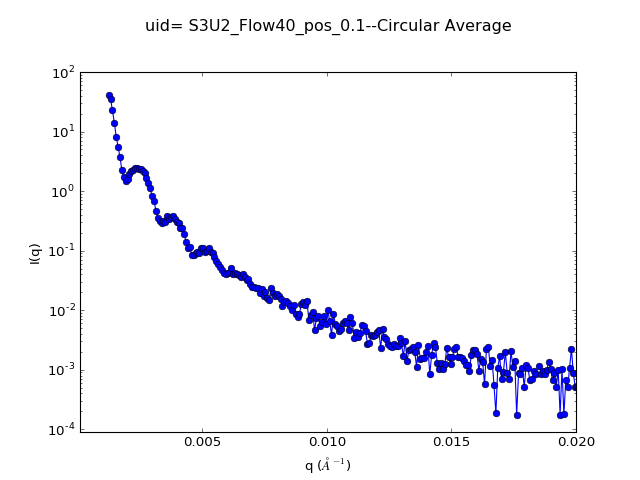

In [25]:
hmask = create_hot_pixel_mask( avg_img, 2**15 )
mask = mask * hmask
hmask = create_hot_pixel_mask( avg_img, 1e8)
qp, iq, q = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs, nx=None,
            plot_ = True, show_pixel= False, xlim=[0.0001,.02], ylim = [0.00009, 1e2], save=True)



### Define ROI
* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
* Create ring mask defined by  edges (all in pixel unit)

In [26]:
uniform = False

### Define a non-uniform distributed rings by giving edges

In [27]:
if not uniform:
    #width = 4  # in pixel
    width = 0.0002*5   
    number_rings=1
    #centers = [ 31, 50, 67, 84, 102, 119] #in pixel
    #centers = [ 0.00235,0.00379,0.00508,0.00636,0.00773, 0.00902] #in A-1
    centers = [ 0.00235,0.00379,0.00508,0.00636,0.00759,0.00889] #in A-1 
    edges = get_non_uniform_edges(  centers, width, number_rings )
    
    inner_radius= None
    outer_radius = None
    width = None
    num_rings = None

### Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)

In [28]:
if uniform:
    inner_radius= 0.0055
    outer_radius = 0.025
    width = 0.002
    num_rings = 9 
    edges = None

In [29]:
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask, inner_radius=inner_radius, unit='A',
        outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges, pargs=setup_pargs   )
qind, pixelist = roi.extract_label_indices(  ring_mask  ) 

In [30]:
md['center'] = center
md['ring_mask'] = ring_mask
md['q_ring_center']= q_ring_center
md['q_ring_val'] = q_ring_val
md['beam_center_x'] =  center[1]
md['beam_center_y']=  center[0]
md['data_dir'] = data_dir

psave_obj(  md, data_dir_ + 'uid=%s-md'%uid_ ) #save the setup parameters

In [31]:
#pload_obj(   data_dir + 'uid=%s-md'%uid_  )

<IPython.core.display.Javascript object>


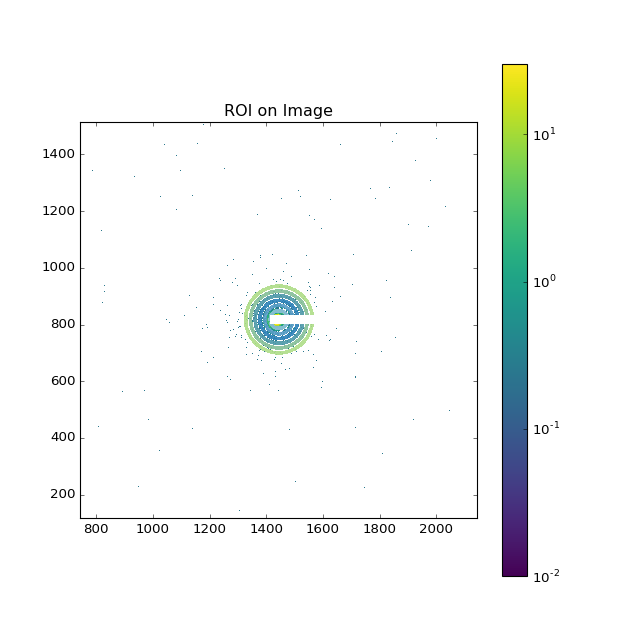

In [34]:
show_ROI_on_image( avg_img, ring_mask, center, label_on = False, rwidth=700, alpha=.9, 
                  vmax=30, save=True, path=data_dir_, uid=uid_)

<IPython.core.display.Javascript object>


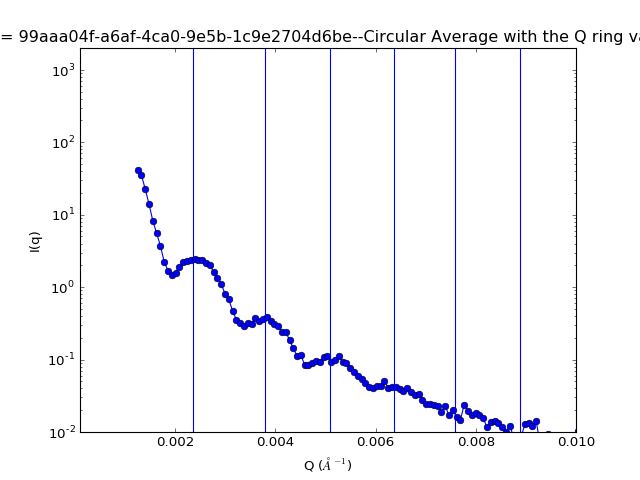

In [35]:
plot_qIq_with_ROI( q, iq, q_ring_center, logs=True, uid=uid, xlim=[0.0001,.01],
                  ylim = [0.01, 2000],        save=True, path=data_dir)

# get the V-ang is about 132.5 and P-ang angle is about 41.5

In [36]:
w = 10
inner_angle=  132.5 -  w
outer_angle =  132.5 + w
num_angles =   1
widtha = (outer_angle - inner_angle )/(num_angles+0.01)

ang_mask_v, ang_center, ang_edges = get_angular_mask( mask,  inner_angle= inner_angle, 
            outer_angle = outer_angle, width = widtha, 
        num_angles = num_angles, center = center, flow_geometry=True )

inner_radius= 0.002  #16
outer_radius = 0.003  #112
width =  0.0002  #2
num_rings = 5
edges = None   
ring_mask_v, q_ring_center, q_ring_val = get_ring_mask(  mask,inner_radius=inner_radius,
                unit='A',outer_radius = outer_radius, 
                width = width, num_rings = num_rings, edges=edges, pargs=setup_pargs   )

seg_mask_v,  rcen_v, acen_v = get_ring_anglar_mask( ring_mask_v, ang_mask_v, q_ring_center, ang_center)

In [ ]:
#show_img( seg_mask_v, logs=True)


In [37]:
w = 10
inner_angle=  41.5 -  w
outer_angle =  41.5 + w
num_angles =   1
widtha = (outer_angle - inner_angle )/(num_angles+0.01)
ang_mask_p, ang_center, ang_edges = get_angular_mask( mask,  inner_angle= inner_angle, 
            outer_angle = outer_angle, width = widtha, 
        num_angles = num_angles, center = center, flow_geometry=True )

inner_radius= 0.002  #16
outer_radius = 0.003  #112
width =  0.0002  #2
num_rings = 5
edges = None   
ring_mask_p, q_ring_center, q_ring_val = get_ring_mask(  mask,inner_radius=inner_radius,
                unit='A',outer_radius = outer_radius, 
                width = width, num_rings = num_rings, edges=edges, pargs=setup_pargs   )

seg_mask_p,  rcen_p, acen_p = get_ring_anglar_mask( ring_mask_p, ang_mask_p, q_ring_center, ang_center)

In [38]:
md['seg_mask_p'] = seg_mask_p
md['seg_mask_v'] = seg_mask_v
md['rcen_p'] = rcen_p
md['acen_p'] = acen_p
md['rcen_v'] = rcen_v
md['acen_v'] = acen_v

# Do loop here

In [39]:
run_num = 1
sub_num = len(uids)
print( run_num, sub_num)

1 5


In [40]:
len(uids)

5

In [41]:
#sub_num = 1

In [42]:
%run /XF11ID/Debug/chxanalys_debug/chxanalys_debug/XPCS_SAXS.py

The 0--th uid to be analyzed is : 99aaa04f-a6af-4ca0-9e5b-1c9e2704d6be
hdf5 path = /XF11ID/data/2016/12/03/fc90f137-fbf4-4a3a-a58a_3837_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_99aaa04f-a6af-4ca0-9e5b-1c9e2704d6be.cmp.
Using a multiprocess to compress the data.
hdf5 path = /XF11ID/data/2016/12/03/fc90f137-fbf4-4a3a-a58a_3837_master.h5
hdf5 path = /XF11ID/data/2016/12/03/fc90f137-fbf4-4a3a-a58a_3837_master.h5
It will create 10 temporary files for parallel compression.


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/fc90f137-fbf4-4a3a-a58a_3837_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/fc90f137-fbf4-4a3a-a58a_3837_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/fc90f137-fbf4-4a3a-a58a_3837_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/fc90f137-fbf4-4a3a-a58a_3837_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/fc90f137-fbf4-4a3a-a58a_3837_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/fc90f137-fbf4-4a3a-a58a_3837_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/fc90f137-fbf4-4a3a-a58a_3837_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/fc90f137-fbf4-4a3a-a58a_3837_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/fc90f137-fbf4-4a3a-a58a_3837_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/fc90f137-fbf4-4a3a-a58a_3837_master.h5
##########
Bad frame list are: [ 0  3  7 10 14 17 21 24 25 27 30 31 34 38 40]
Combining the seperated compressed files together...
S3/U2 40ul/hr dxv2=0.1 1k frames 750Hz
With compression, the good_start frame number is: 42 
The good_end frame number is: 1000 
In this g2 calculation, the buf and lev number are: 8--9--
Bad frame involved and will be precessed!
958 frames will be processed...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 5/5 [00:01<00:00,  3.91it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/99aaa04f-a6af-4ca0-9e5b-1c9e2704d6be/ with filename as uid=99aaa04f-a6af-4ca0-9e5b-1c9e2704d6be_1a_mqv--g2.csv
The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/99aaa04f-a6af-4ca0-9e5b-1c9e2704d6be/ with filename as uid=99aaa04f-a6af-4ca0-9e5b-1c9e2704d6be_1a_mqv_fit--g2.csv


<IPython.core.display.Javascript object>


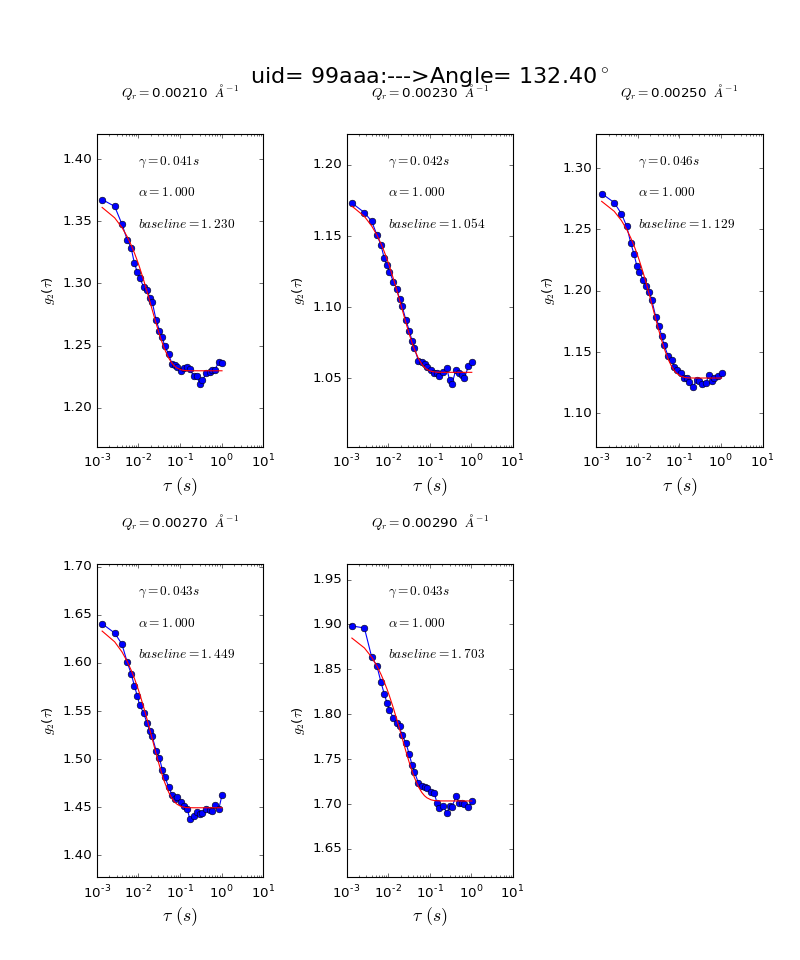

The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/99aaa04f-a6af-4ca0-9e5b-1c9e2704d6be/99aaa04f-a6af-4ca0-9e5b-1c9e2704d6be_1a_mqv_fit_para.csv
The fitted diffusion coefficient D0 is:  3.495e+06   A^2S-1


<IPython.core.display.Javascript object>


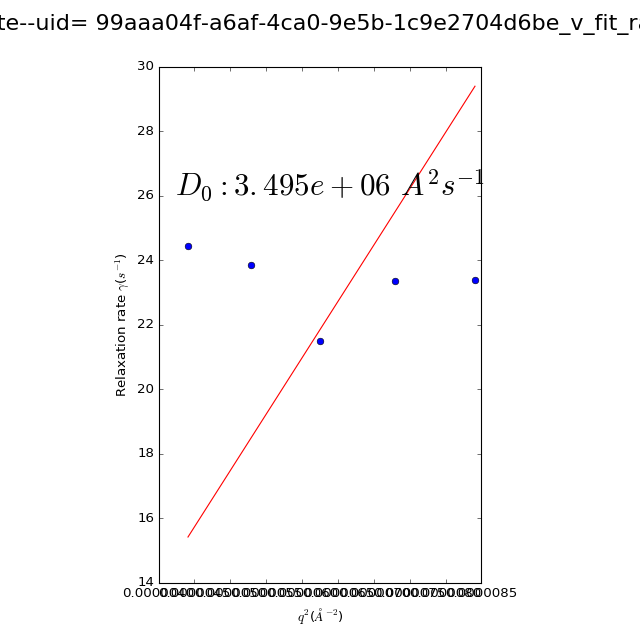

In this g2 calculation, the buf and lev number are: 8--9--
Bad frame involved and will be precessed!
958 frames will be processed...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/99aaa04f-a6af-4ca0-9e5b-1c9e2704d6be/ with filename as uid=99aaa04f-a6af-4ca0-9e5b-1c9e2704d6be_1a_mqp--g2.csv
The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/99aaa04f-a6af-4ca0-9e5b-1c9e2704d6be/ with filename as uid=99aaa04f-a6af-4ca0-9e5b-1c9e2704d6be_1a_mqp_fit--g2.csv


<IPython.core.display.Javascript object>


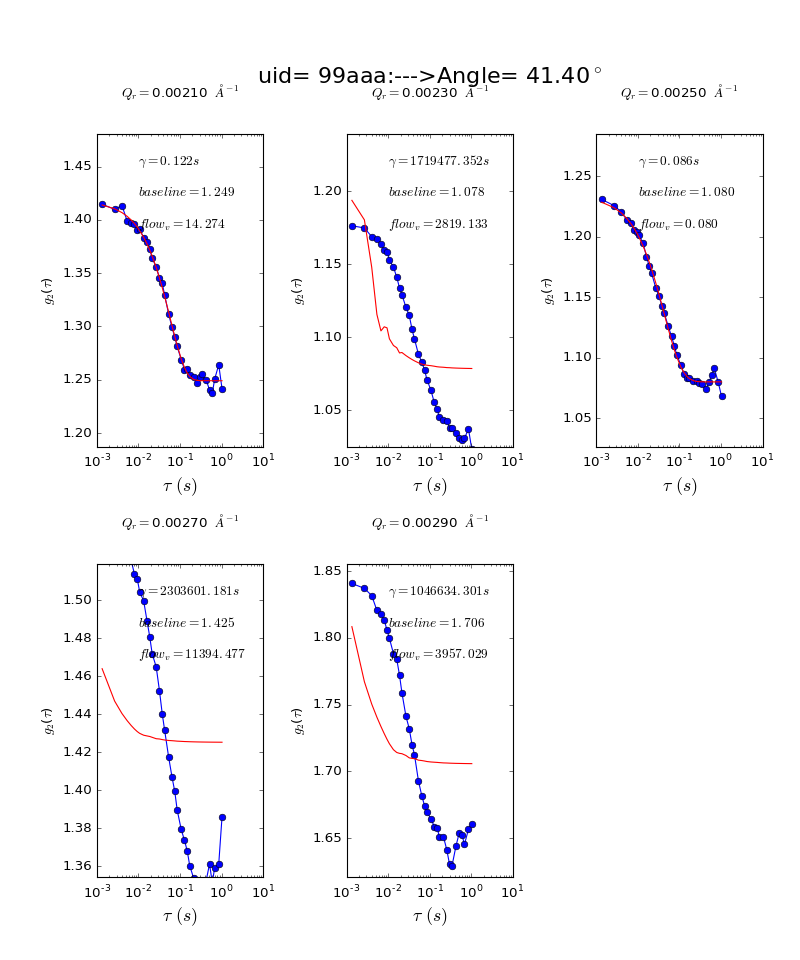

The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/99aaa04f-a6af-4ca0-9e5b-1c9e2704d6be/99aaa04f-a6af-4ca0-9e5b-1c9e2704d6be_1a_mqp_fit_para.csv
The fitted diffusion coefficient D0 is:  5.188e+05   A^2S-1


<IPython.core.display.Javascript object>


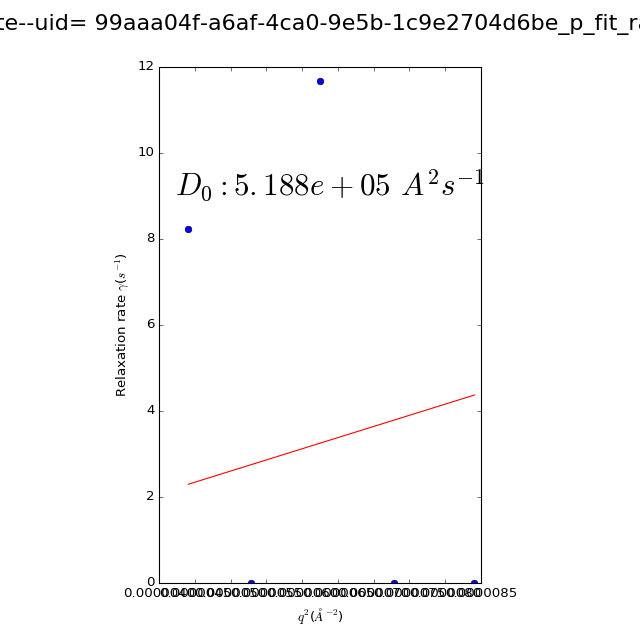

****************************************

The 1--th uid to be analyzed is : dd781ed5-2c32-44c2-9782-bb07e6f293fa
hdf5 path = /XF11ID/data/2016/12/03/020ccaf1-6618-4d11-8ede_3838_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_dd781ed5-2c32-44c2-9782-bb07e6f293fa.cmp.
Using a multiprocess to compress the data.
hdf5 path = /XF11ID/data/2016/12/03/020ccaf1-6618-4d11-8ede_3838_master.h5
hdf5 path = /XF11ID/data/2016/12/03/020ccaf1-6618-4d11-8ede_3838_master.h5
It will create 10 temporary files for parallel compression.


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/020ccaf1-6618-4d11-8ede_3838_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/020ccaf1-6618-4d11-8ede_3838_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/020ccaf1-6618-4d11-8ede_3838_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/020ccaf1-6618-4d11-8ede_3838_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/020ccaf1-6618-4d11-8ede_3838_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/020ccaf1-6618-4d11-8ede_3838_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/020ccaf1-6618-4d11-8ede_3838_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/020ccaf1-6618-4d11-8ede_3838_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/020ccaf1-6618-4d11-8ede_3838_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/020ccaf1-6618-4d11-8ede_3838_master.h5
##########
No bad frames are involved.
Combining the seperated compressed files together...
S3/U2 40ul/hr dxv2=0.1 1k frames 750Hz
With compression, the good_start frame number is: 42 
The good_end frame number is: 1000 
In this g2 calculation, the buf and lev number are: 8--9--
958 frames will be processed...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 5/5 [00:01<00:00,  4.36it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/dd781ed5-2c32-44c2-9782-bb07e6f293fa/ with filename as uid=dd781ed5-2c32-44c2-9782-bb07e6f293fa_1a_mqv--g2.csv
The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/dd781ed5-2c32-44c2-9782-bb07e6f293fa/ with filename as uid=dd781ed5-2c32-44c2-9782-bb07e6f293fa_1a_mqv_fit--g2.csv


<IPython.core.display.Javascript object>


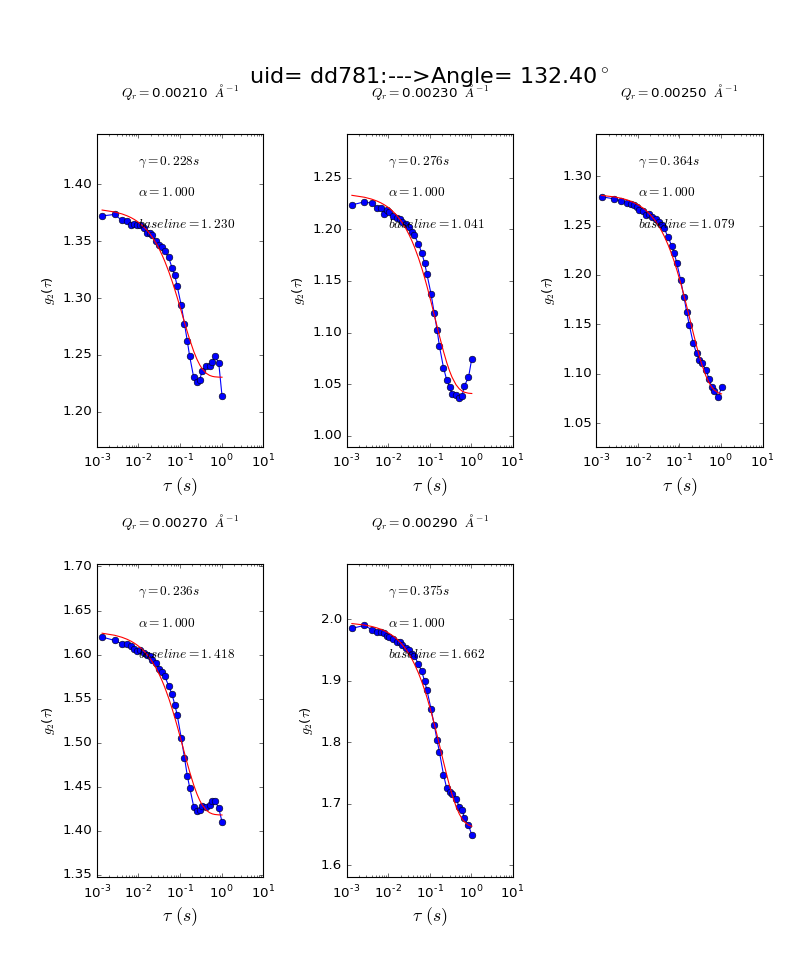

The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/dd781ed5-2c32-44c2-9782-bb07e6f293fa/dd781ed5-2c32-44c2-9782-bb07e6f293fa_1a_mqv_fit_para.csv
The fitted diffusion coefficient D0 is:  5.179e+05   A^2S-1


<IPython.core.display.Javascript object>


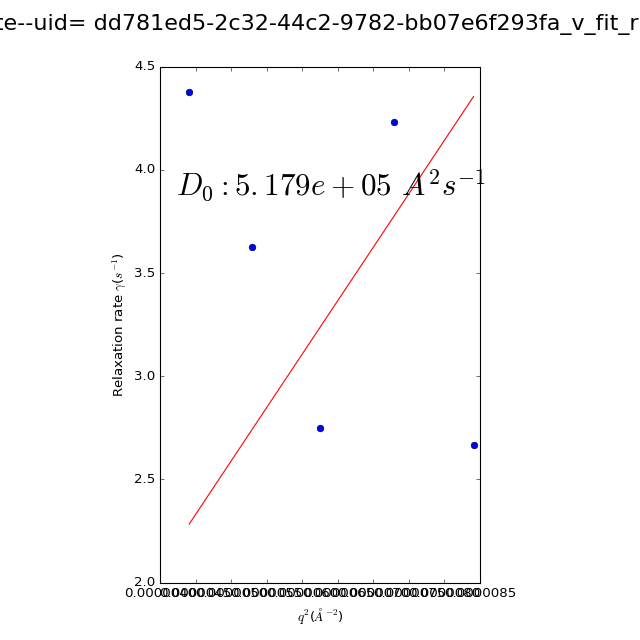

In this g2 calculation, the buf and lev number are: 8--9--
958 frames will be processed...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 5/5 [00:01<00:00,  4.70it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/dd781ed5-2c32-44c2-9782-bb07e6f293fa/ with filename as uid=dd781ed5-2c32-44c2-9782-bb07e6f293fa_1a_mqp--g2.csv
The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/dd781ed5-2c32-44c2-9782-bb07e6f293fa/ with filename as uid=dd781ed5-2c32-44c2-9782-bb07e6f293fa_1a_mqp_fit--g2.csv


<IPython.core.display.Javascript object>


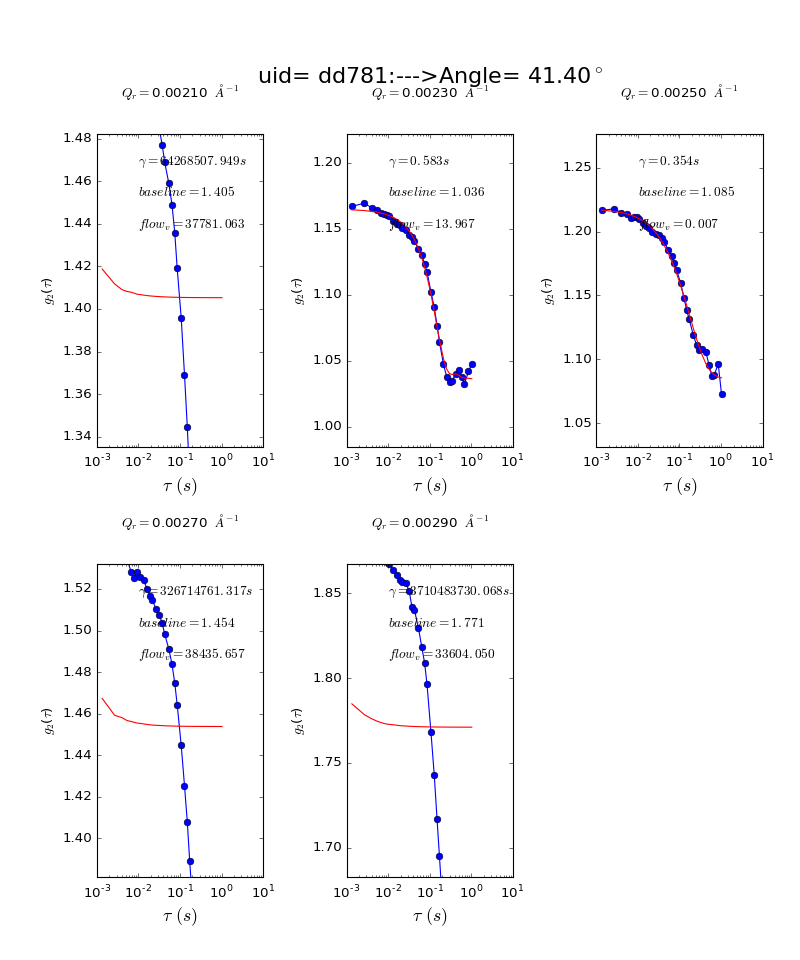

The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/dd781ed5-2c32-44c2-9782-bb07e6f293fa/dd781ed5-2c32-44c2-9782-bb07e6f293fa_1a_mqp_fit_para.csv
The fitted diffusion coefficient D0 is:  1.271e+05   A^2S-1


<IPython.core.display.Javascript object>


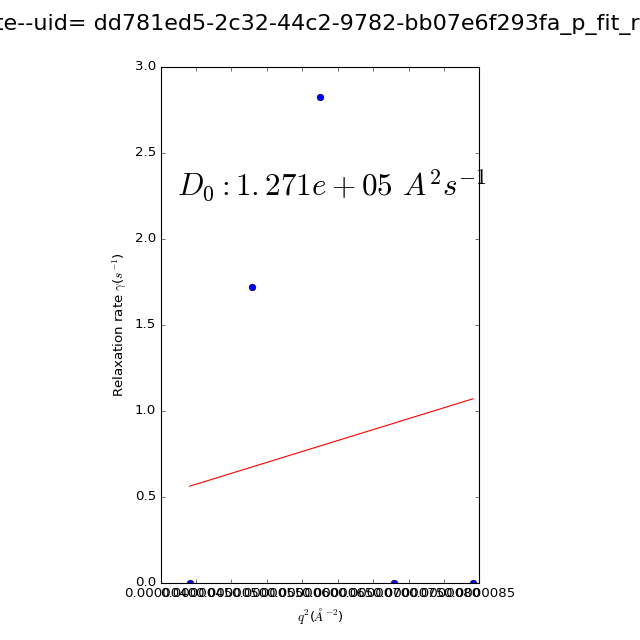

****************************************

The 2--th uid to be analyzed is : 073f83ac-055f-49f5-ad36-3e0e5d5589d0
hdf5 path = /XF11ID/data/2016/12/03/3c1336a4-9902-4525-9e32_3839_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_073f83ac-055f-49f5-ad36-3e0e5d5589d0.cmp.
Using a multiprocess to compress the data.
hdf5 path = /XF11ID/data/2016/12/03/3c1336a4-9902-4525-9e32_3839_master.h5
hdf5 path = /XF11ID/data/2016/12/03/3c1336a4-9902-4525-9e32_3839_master.h5
It will create 10 temporary files for parallel compression.


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/3c1336a4-9902-4525-9e32_3839_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/3c1336a4-9902-4525-9e32_3839_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/3c1336a4-9902-4525-9e32_3839_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/3c1336a4-9902-4525-9e32_3839_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/3c1336a4-9902-4525-9e32_3839_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/3c1336a4-9902-4525-9e32_3839_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/3c1336a4-9902-4525-9e32_3839_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/3c1336a4-9902-4525-9e32_3839_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/3c1336a4-9902-4525-9e32_3839_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/3c1336a4-9902-4525-9e32_3839_master.h5
##########
Bad frame list are: [1]
Combining the seperated compressed files together...
S3/U2 40ul/hr dxv2=0.1 1k frames 750Hz
With compression, the good_start frame number is: 42 
The good_end frame number is: 1000 
In this g2 calculation, the buf and lev number are: 8--9--
Bad frame involved and will be precessed!
958 frames will be processed...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/073f83ac-055f-49f5-ad36-3e0e5d5589d0/ with filename as uid=073f83ac-055f-49f5-ad36-3e0e5d5589d0_1a_mqv--g2.csv
The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/073f83ac-055f-49f5-ad36-3e0e5d5589d0/ with filename as uid=073f83ac-055f-49f5-ad36-3e0e5d5589d0_1a_mqv_fit--g2.csv


<IPython.core.display.Javascript object>


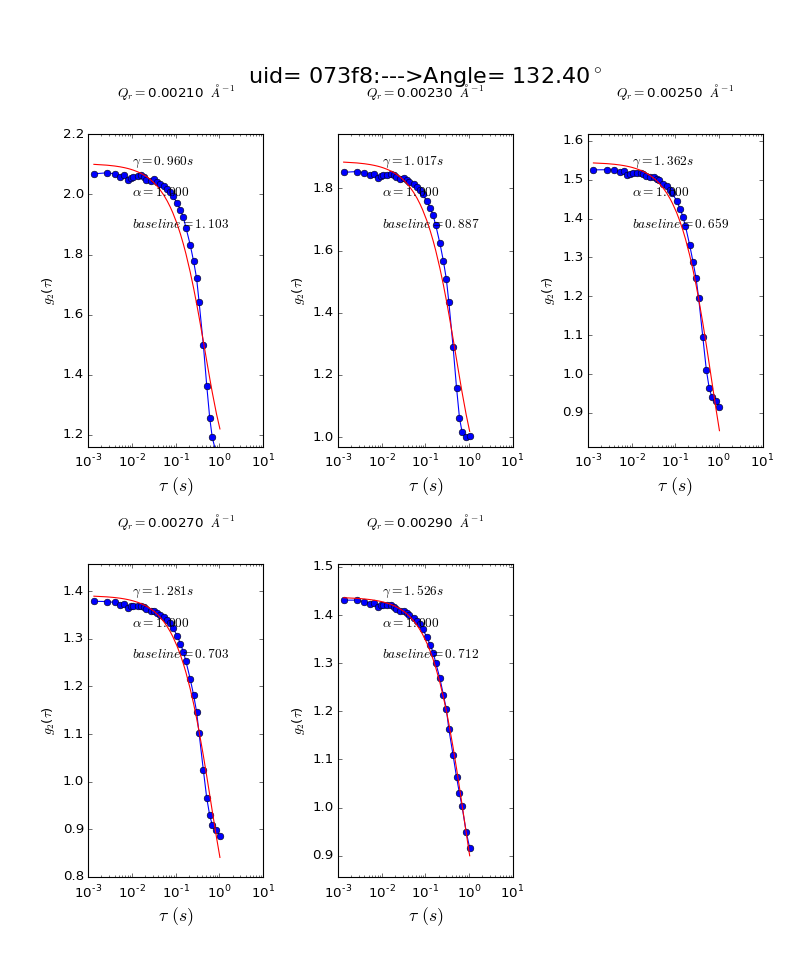

The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/073f83ac-055f-49f5-ad36-3e0e5d5589d0/073f83ac-055f-49f5-ad36-3e0e5d5589d0_1a_mqv_fit_para.csv
The fitted diffusion coefficient D0 is:  1.217e+05   A^2S-1


<IPython.core.display.Javascript object>


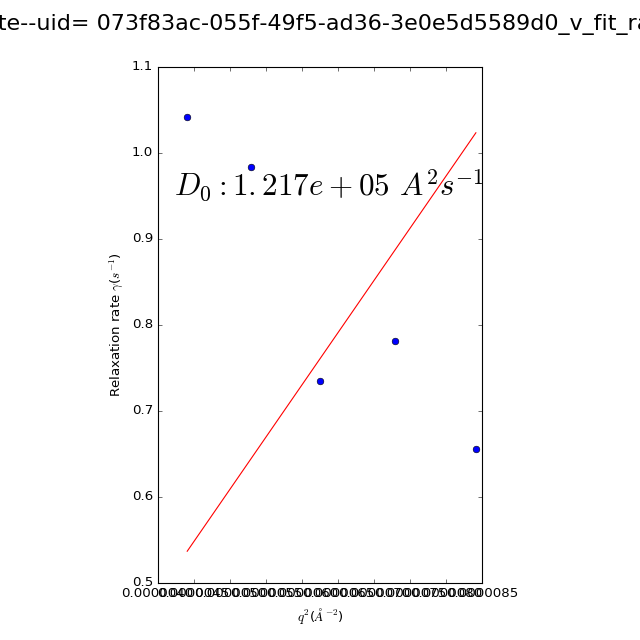

In this g2 calculation, the buf and lev number are: 8--9--
Bad frame involved and will be precessed!
958 frames will be processed...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 5/5 [00:01<00:00,  4.12it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/073f83ac-055f-49f5-ad36-3e0e5d5589d0/ with filename as uid=073f83ac-055f-49f5-ad36-3e0e5d5589d0_1a_mqp--g2.csv
The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/073f83ac-055f-49f5-ad36-3e0e5d5589d0/ with filename as uid=073f83ac-055f-49f5-ad36-3e0e5d5589d0_1a_mqp_fit--g2.csv


<IPython.core.display.Javascript object>


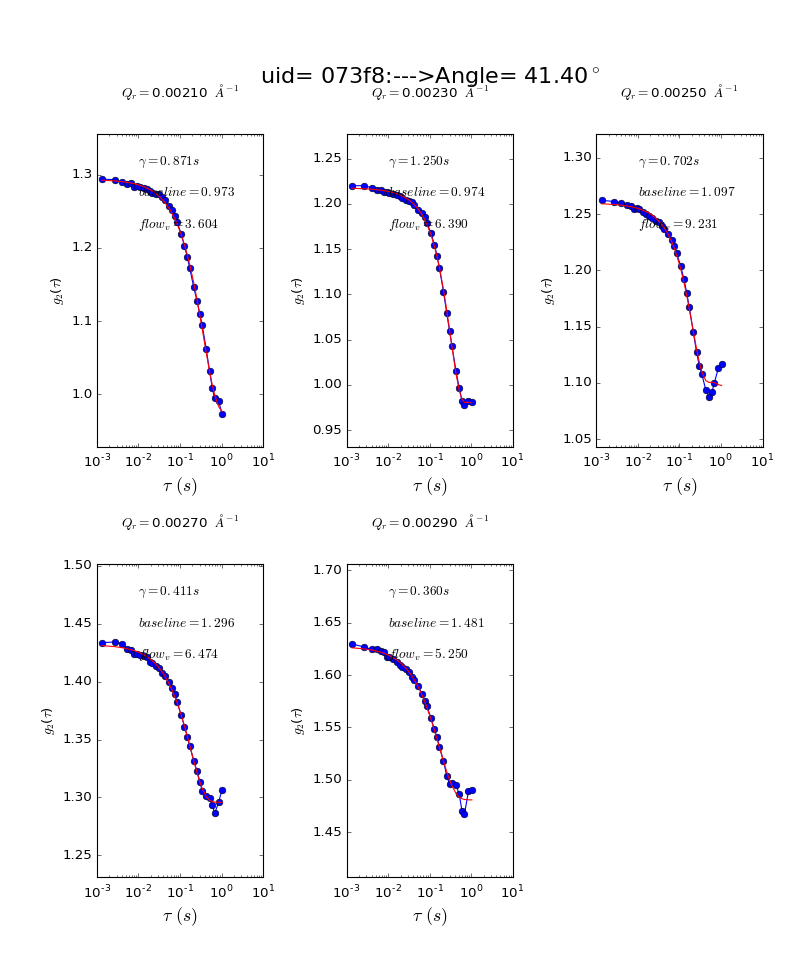

The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/073f83ac-055f-49f5-ad36-3e0e5d5589d0/073f83ac-055f-49f5-ad36-3e0e5d5589d0_1a_mqp_fit_para.csv
The fitted diffusion coefficient D0 is:  2.818e+05   A^2S-1


<IPython.core.display.Javascript object>


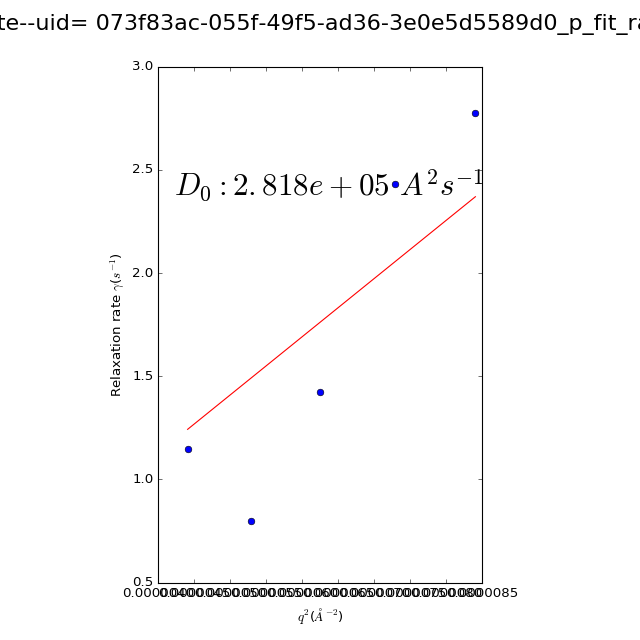

****************************************

The 3--th uid to be analyzed is : 57c3362b-175c-4aea-a42e-d25d21c88dd1
hdf5 path = /XF11ID/data/2016/12/03/479a024e-50fb-403d-8b22_3840_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_57c3362b-175c-4aea-a42e-d25d21c88dd1.cmp.
Using a multiprocess to compress the data.
hdf5 path = /XF11ID/data/2016/12/03/479a024e-50fb-403d-8b22_3840_master.h5
hdf5 path = /XF11ID/data/2016/12/03/479a024e-50fb-403d-8b22_3840_master.h5
It will create 10 temporary files for parallel compression.


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/479a024e-50fb-403d-8b22_3840_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/479a024e-50fb-403d-8b22_3840_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/479a024e-50fb-403d-8b22_3840_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/479a024e-50fb-403d-8b22_3840_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/479a024e-50fb-403d-8b22_3840_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/479a024e-50fb-403d-8b22_3840_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/479a024e-50fb-403d-8b22_3840_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/479a024e-50fb-403d-8b22_3840_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/479a024e-50fb-403d-8b22_3840_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/479a024e-50fb-403d-8b22_3840_master.h5
##########
Bad frame list are: [0]
Combining the seperated compressed files together...
S3/U2 40ul/hr dxv2=0.1 1k frames 750Hz
With compression, the good_start frame number is: 42 
The good_end frame number is: 1000 
In this g2 calculation, the buf and lev number are: 8--9--
Bad frame involved and will be precessed!
958 frames will be processed...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 5/5 [00:01<00:00,  2.85it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/57c3362b-175c-4aea-a42e-d25d21c88dd1/ with filename as uid=57c3362b-175c-4aea-a42e-d25d21c88dd1_1a_mqv--g2.csv
The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/57c3362b-175c-4aea-a42e-d25d21c88dd1/ with filename as uid=57c3362b-175c-4aea-a42e-d25d21c88dd1_1a_mqv_fit--g2.csv


<IPython.core.display.Javascript object>


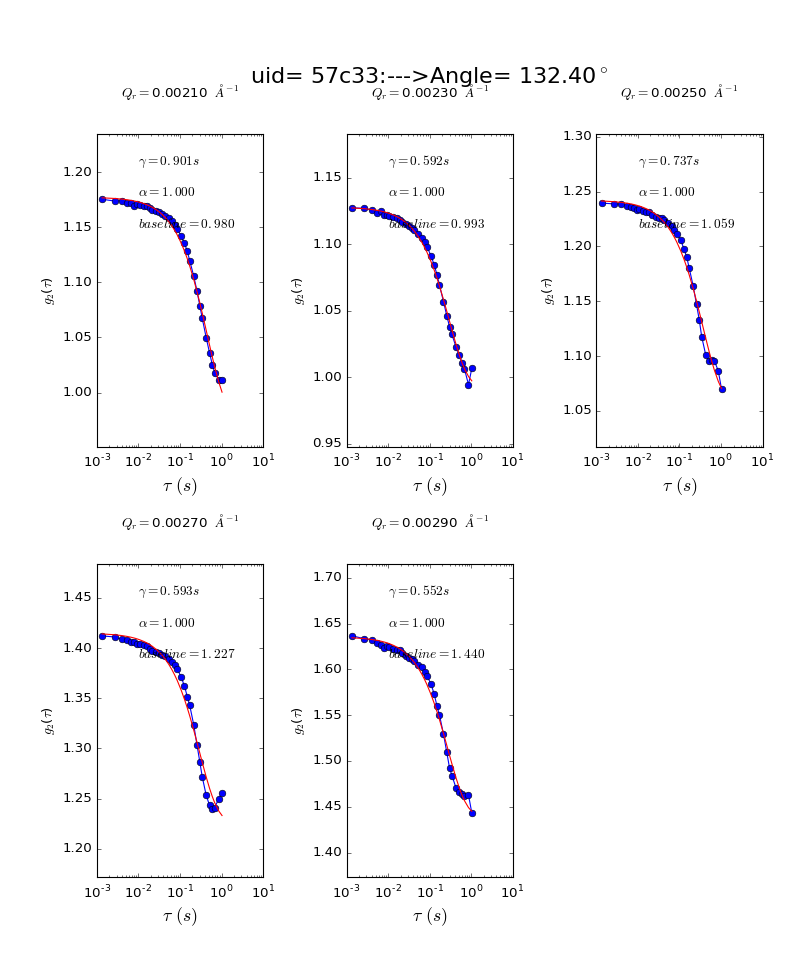

The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/57c3362b-175c-4aea-a42e-d25d21c88dd1/57c3362b-175c-4aea-a42e-d25d21c88dd1_1a_mqv_fit_para.csv
The fitted diffusion coefficient D0 is:  2.370e+05   A^2S-1


<IPython.core.display.Javascript object>


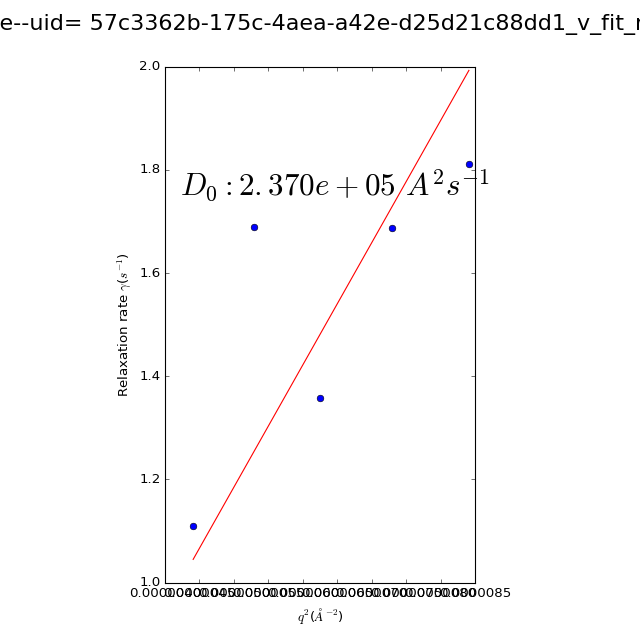

In this g2 calculation, the buf and lev number are: 8--9--
Bad frame involved and will be precessed!
958 frames will be processed...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 5/5 [00:01<00:00,  3.60it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/57c3362b-175c-4aea-a42e-d25d21c88dd1/ with filename as uid=57c3362b-175c-4aea-a42e-d25d21c88dd1_1a_mqp--g2.csv
The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/57c3362b-175c-4aea-a42e-d25d21c88dd1/ with filename as uid=57c3362b-175c-4aea-a42e-d25d21c88dd1_1a_mqp_fit--g2.csv


<IPython.core.display.Javascript object>


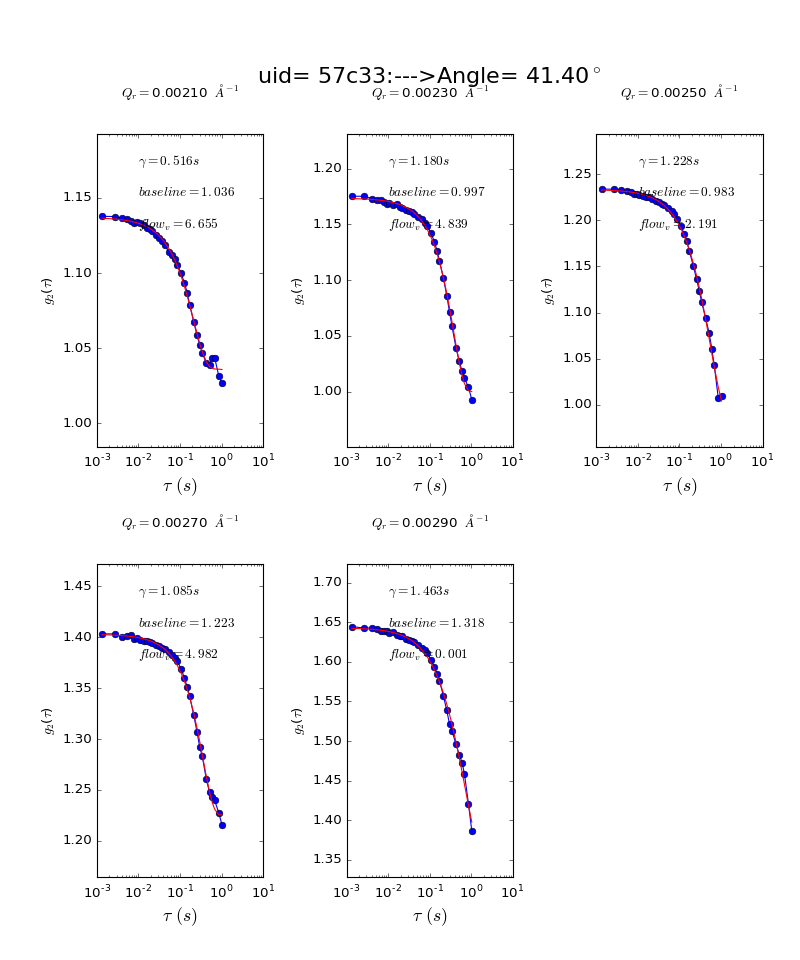

The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/57c3362b-175c-4aea-a42e-d25d21c88dd1/57c3362b-175c-4aea-a42e-d25d21c88dd1_1a_mqp_fit_para.csv
The fitted diffusion coefficient D0 is:  1.454e+05   A^2S-1


<IPython.core.display.Javascript object>


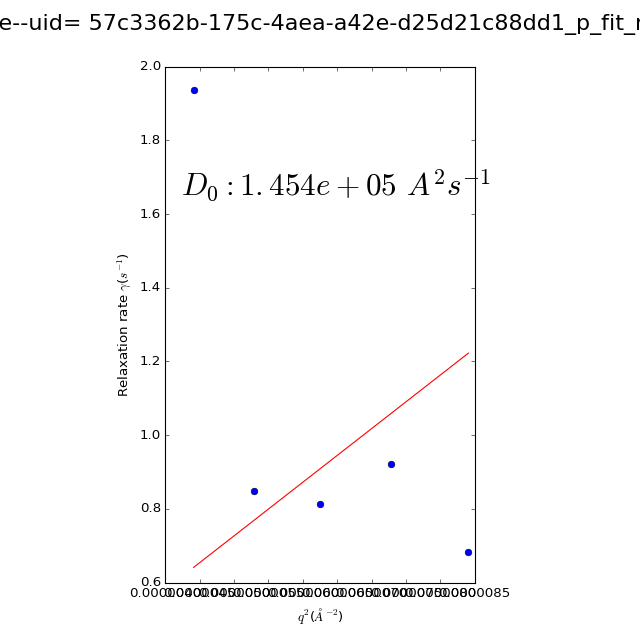

****************************************

The 4--th uid to be analyzed is : 667327b7-4661-4e5b-9421-ae5d00723086
hdf5 path = /XF11ID/data/2016/12/03/45e9c951-ab3d-439d-a51d_3841_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_667327b7-4661-4e5b-9421-ae5d00723086.cmp.
Using a multiprocess to compress the data.
hdf5 path = /XF11ID/data/2016/12/03/45e9c951-ab3d-439d-a51d_3841_master.h5
hdf5 path = /XF11ID/data/2016/12/03/45e9c951-ab3d-439d-a51d_3841_master.h5
It will create 10 temporary files for parallel compression.


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/45e9c951-ab3d-439d-a51d_3841_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/45e9c951-ab3d-439d-a51d_3841_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/45e9c951-ab3d-439d-a51d_3841_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/45e9c951-ab3d-439d-a51d_3841_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/45e9c951-ab3d-439d-a51d_3841_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/45e9c951-ab3d-439d-a51d_3841_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/45e9c951-ab3d-439d-a51d_3841_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/45e9c951-ab3d-439d-a51d_3841_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/45e9c951-ab3d-439d-a51d_3841_master.h5


/opt/conda_envs/analysis/lib/python3.5/site-packages/pymongo/topology.py:75: UserWarning: MongoClient opened before fork. Create MongoClient with connect=False, or create client after forking. See PyMongo's documentation for details: http://api.mongodb.org/python/current/faq.html#using-pymongo-with-multiprocessing>
  "MongoClient opened before fork. Create MongoClient "


hdf5 path = /XF11ID/data/2016/12/03/45e9c951-ab3d-439d-a51d_3841_master.h5
##########
No bad frames are involved.
Combining the seperated compressed files together...
S3/U2 40ul/hr dxv2=0.1 1k frames 750Hz
With compression, the good_start frame number is: 42 
The good_end frame number is: 1000 
In this g2 calculation, the buf and lev number are: 8--9--
958 frames will be processed...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 5/5 [00:01<00:00,  3.47it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/667327b7-4661-4e5b-9421-ae5d00723086/ with filename as uid=667327b7-4661-4e5b-9421-ae5d00723086_1a_mqv--g2.csv
The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/667327b7-4661-4e5b-9421-ae5d00723086/ with filename as uid=667327b7-4661-4e5b-9421-ae5d00723086_1a_mqv_fit--g2.csv


<IPython.core.display.Javascript object>


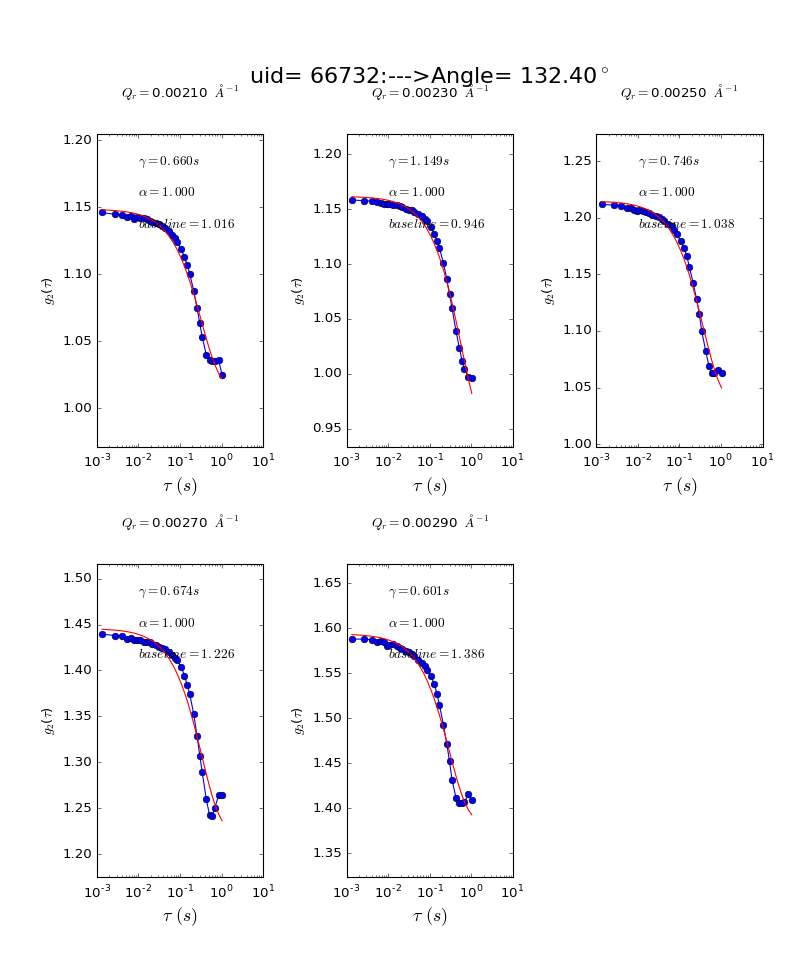

The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/667327b7-4661-4e5b-9421-ae5d00723086/667327b7-4661-4e5b-9421-ae5d00723086_1a_mqv_fit_para.csv
The fitted diffusion coefficient D0 is:  2.115e+05   A^2S-1


<IPython.core.display.Javascript object>


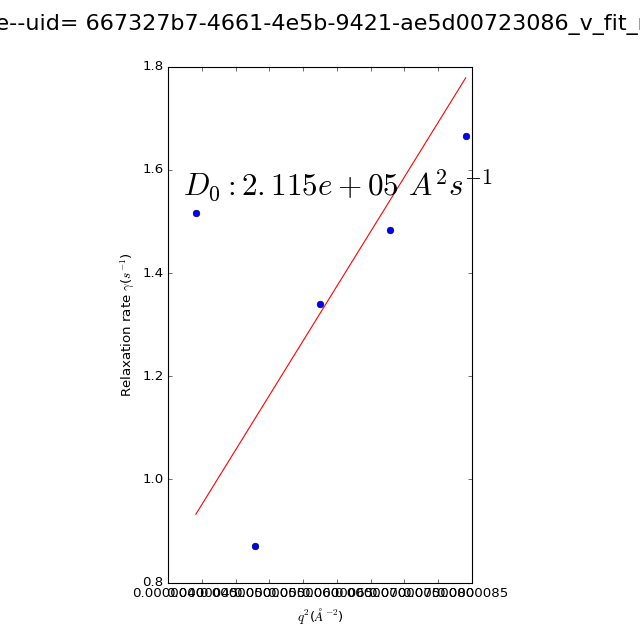

In this g2 calculation, the buf and lev number are: 8--9--
958 frames will be processed...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting assign the tasks...


  0%|          | 0/5 [00:00<?, ?it/s]

Starting running the tasks...


100%|██████████| 5/5 [00:01<00:00,  1.93it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/667327b7-4661-4e5b-9421-ae5d00723086/ with filename as uid=667327b7-4661-4e5b-9421-ae5d00723086_1a_mqp--g2.csv
The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/667327b7-4661-4e5b-9421-ae5d00723086/ with filename as uid=667327b7-4661-4e5b-9421-ae5d00723086_1a_mqp_fit--g2.csv


<IPython.core.display.Javascript object>


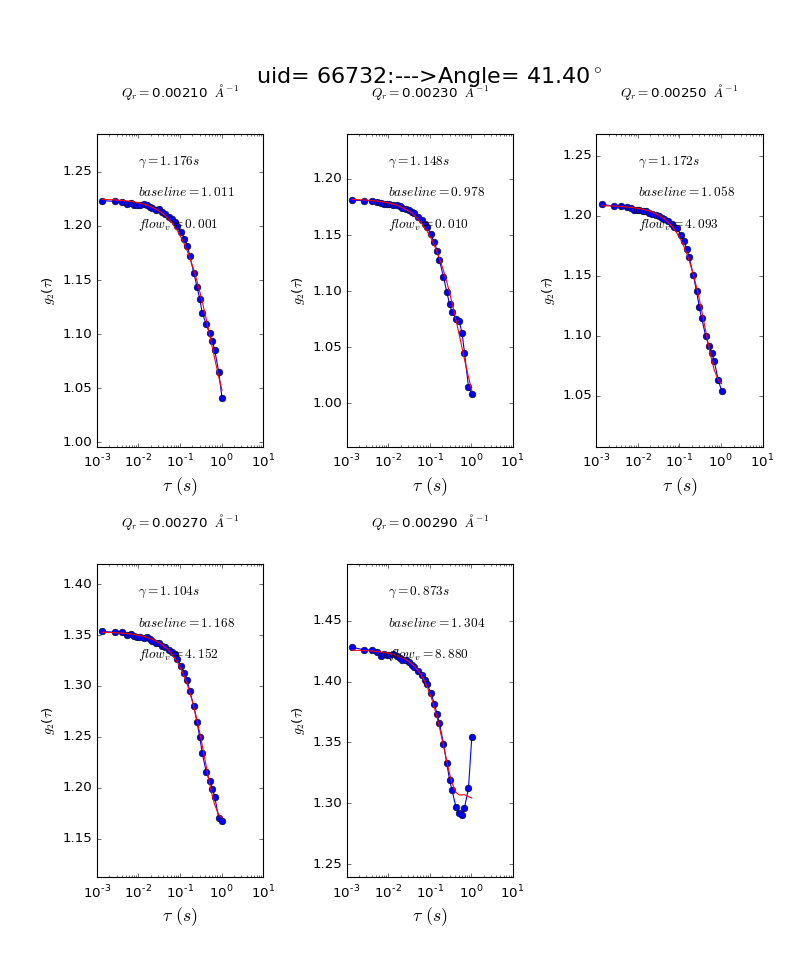

The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/667327b7-4661-4e5b-9421-ae5d00723086/667327b7-4661-4e5b-9421-ae5d00723086_1a_mqp_fit_para.csv
The fitted diffusion coefficient D0 is:  1.423e+05   A^2S-1


<IPython.core.display.Javascript object>


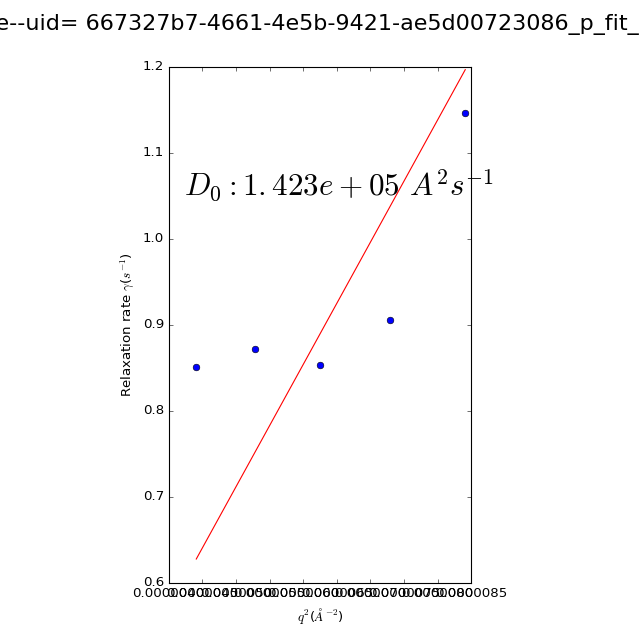

****************************************



In [43]:
g2s, taus, useful_uids  = multi_uids_saxs_flow_xpcs_analysis(   uids, md, run_num, sub_num, 
                                                good_start=10, good_end= None,
                                  force_compress=False,  fit = True,  para_run= True  )

## Create PDF report for each uid

In [44]:
useful_uids

{1: {1: '99aaa04f-a6af-4ca0-9e5b-1c9e2704d6be',
  2: 'dd781ed5-2c32-44c2-9782-bb07e6f293fa',
  3: '073f83ac-055f-49f5-ad36-3e0e5d5589d0',
  4: '57c3362b-175c-4aea-a42e-d25d21c88dd1',
  5: '667327b7-4661-4e5b-9421-ae5d00723086'}}

* Create multi PDF report for each uid

In [73]:
append_name = '_1'

create_multi_pdf_reports_for_uids( useful_uids, g2s, data_dir, report_type='flow',append_name=append_name )


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/XPCS_Analysis_Report_for_uid=99aaa04f-a6af-4ca0-9e5b-1c9e2704d6be_1.pdf
****************************************

****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/XPCS_Analysis_Report_for_uid=dd781ed5-2c32-44c2-9782-bb07e6f293fa_1.pdf
****************************************

****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/XPCS_Analysis_Report_for_uid=073f83ac-055f-49f5-ad36-3e0e5d5589d0_1.pdf
****************************************

****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/XPCS_Analysis_Report_for_uid=57c3362b-175c-4aea-a42e-d25d21c88dd1_1.pdf
*

### Attach each g2 result to the corresponding olog entry

In [69]:
os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'

In [70]:
from chxanalys.chx_olog import LogEntry,Attachment, update_olog_uid, update_olog_id

In [71]:
useful_uids[1]

{1: '99aaa04f-a6af-4ca0-9e5b-1c9e2704d6be',
 2: 'dd781ed5-2c32-44c2-9782-bb07e6f293fa',
 3: '073f83ac-055f-49f5-ad36-3e0e5d5589d0',
 4: '57c3362b-175c-4aea-a42e-d25d21c88dd1',
 5: '667327b7-4661-4e5b-9421-ae5d00723086'}

In [74]:
for key in list( useful_uids.keys()):
    for k in list( useful_uids[key]):
        uid_k = useful_uids[key][k]
        if append_name!='':
            filename = data_dir + 'XPCS_Analysis_Report_for_uid=%s%s.pdf'%(uid_k, append_name)
        else:
            filename = data_dir + 'XPCS_Analysis_Report_for_uid=%s.pdf'%uid_k 
        atch=[  Attachment(open(filename, 'rb')) ] 
        update_olog_uid( uid=uid_k, text='Add XPCS Analysis PDF Report', attachments= atch )
        #update_olog_uid( uid=uid_, text='Add XPCS Analysis PDF Report', attachments= atch )

## Create one PDF including all uids

In [50]:
#create_one_pdf_reports_for_uids( useful_uids, g2s, data_dir_, filename=uid_ )

In [51]:
%run /XF11ID/Debug/chxanalys_debug/chxanalys_debug/XPCS_SAXS.py
%run /XF11ID/Debug/chxanalys_debug/chxanalys_debug/Create_Report.py

In [52]:
g2s[key].keys()

dict_keys([1, 2, 3, 4, 5])

# Do average Here

In [56]:
g2s_average ={} # g2s[run] = g2 of each time series average
g2s_average['p'] ={}
g2s_average['v'] ={}
for key in list( g2s.keys()):
    g2s_average['p'][key] = np.zeros_like( g2s[key][1]['p'])
    g2s_average['v'][key] = np.zeros_like( g2s[key][1]['v'])
    i=1
    for sub_key in list( g2s[key].keys() ):
        #print (g2s_average[key].shape, g2s[key][sub_key].shape  )        
        try:
            g2s_average['p'][key] +=  g2s[key][sub_key]['p']
            g2s_average['v'][key] +=  g2s[key][sub_key]['v']
            i +=1
            print( 'Run= %s--sub_run= %s-- pass'%(key, sub_key) )
            #print( 'sub= %s,Doing average here'%sub_key)
        except:            
            print( 'sub= %s,Can not Doing average here'%sub_key)
            pass
    g2s_average['p'][key] /= i-1
    g2s_average['v'][key] /= i-1

Run= 1--sub_run= 1-- pass
Run= 1--sub_run= 2-- pass
Run= 1--sub_run= 3-- pass
Run= 1--sub_run= 4-- pass
Run= 1--sub_run= 5-- pass


# Save Data

In [57]:
for key in list( g2s.keys()):
    res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                  path=data_dir_, uid=  uid_ + '@run--%s-para'%key )    
    save_saxs_g2(    g2s_average['p'][key], res_pargs )

    res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                  path=data_dir_, uid=  uid_ + '@run--%s-vert'%key )    
    save_saxs_g2(    g2s_average['v'][key], res_pargs )
    

The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/Average/ with filename as uid=S3U2_Flow40_pos_0.1@run--1-para--g2.csv
The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/Average/ with filename as uid=S3U2_Flow40_pos_0.1@run--1-vert--g2.csv


# Plot All the g2 Data

In [58]:
if False:
    for key in list( g2s.keys()):
        for sub_key in  list( g2s[key].keys()):
            res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                          path=data_dir_, uid=  uid_ + '@run--%s--subrun--%s'%(key, sub_key) )
            plot_saxs_g2( g2s[key][sub_key], taus,  vlim=[0.95, 1.05], res_pargs=res_pargs) 


# Plot Avergaed Data

In [59]:
if False:
    for key in list( g2s.keys()):
        
        res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                  path=data_dir_, uid=  uid_ + '@run--%s-para'%key )  
        plot_saxs_g2( g2s_average['p'][key], taus,  vlim=[0.95, 1.05], res_pargs=res_pargs)    

        res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                  path=data_dir_, uid=  uid_ + '@run--%s-vert'%key )    
        plot_saxs_g2( g2s_average['v'][key], taus,  vlim=[0.95, 1.05], res_pargs=res_pargs)


# Fit Averaged Data

In [60]:
fit = True

The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/Average/ with filename as uid=S3U2_Flow40_pos_0.1_1a_mqp--g2.csv


<IPython.core.display.Javascript object>


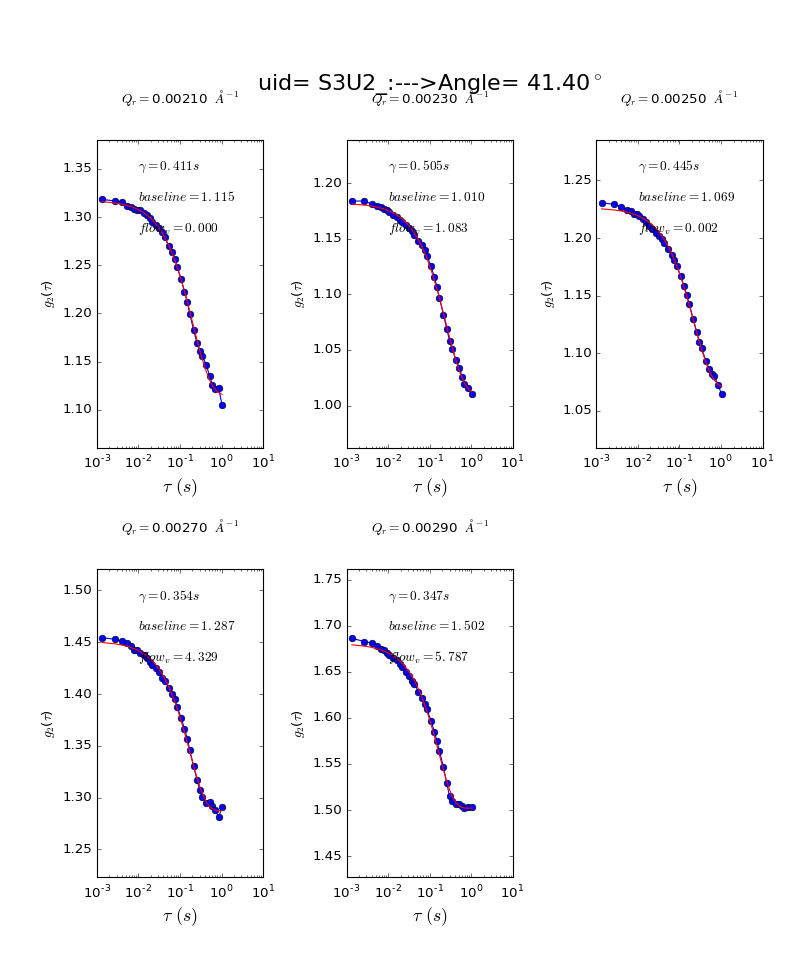

The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/Average/S3U2_Flow40_pos_0.1_1a_mqp_fit_para.csv
The fitted diffusion coefficient D0 is:  3.807e+05   A^2S-1


<IPython.core.display.Javascript object>


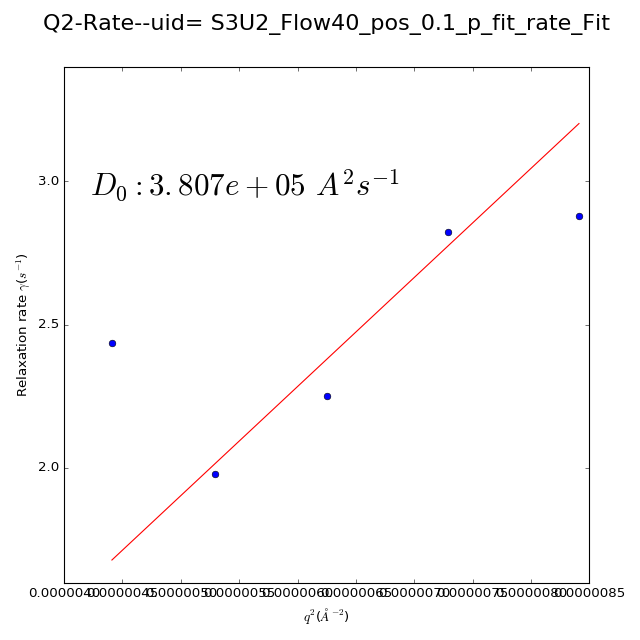

The correlation function is saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/Average/ with filename as uid=S3U2_Flow40_pos_0.1_1a_mqv--g2.csv


<IPython.core.display.Javascript object>


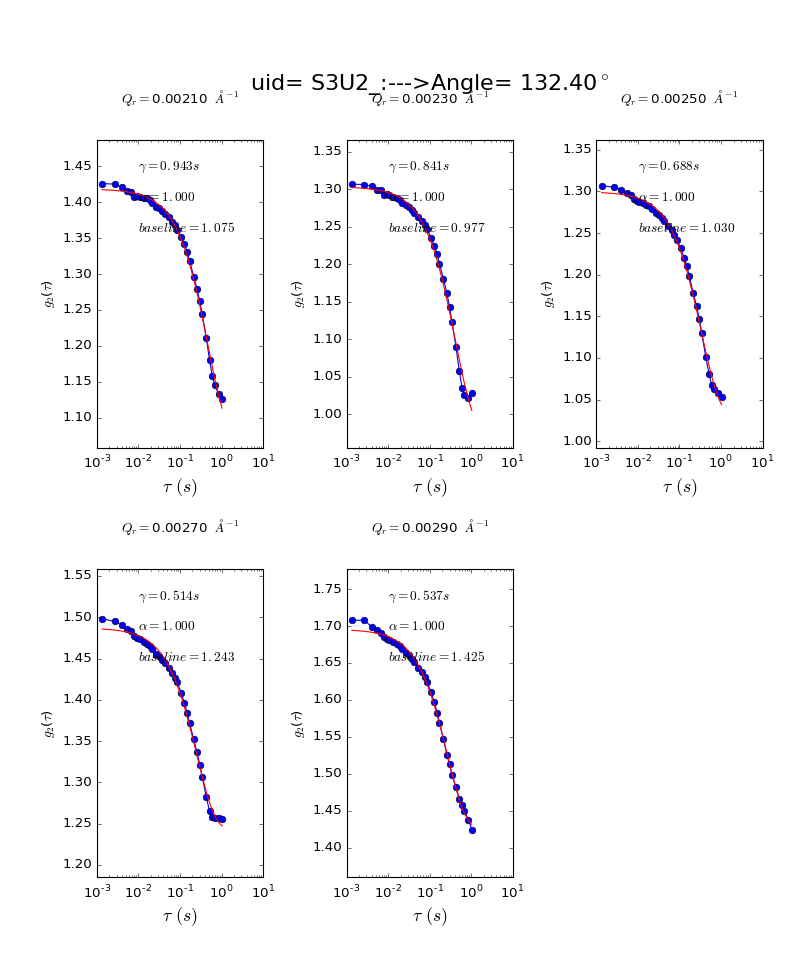

The g2 fitting parameters are saved in /XF11ID/analysis/2016_3/colosqui/Results/S3U2_Flow40_pos_0.1/Average/S3U2_Flow40_pos_0.1_1a_mqv_fit_para.csv
The fitted diffusion coefficient D0 is:  2.371e+05   A^2S-1


<IPython.core.display.Javascript object>


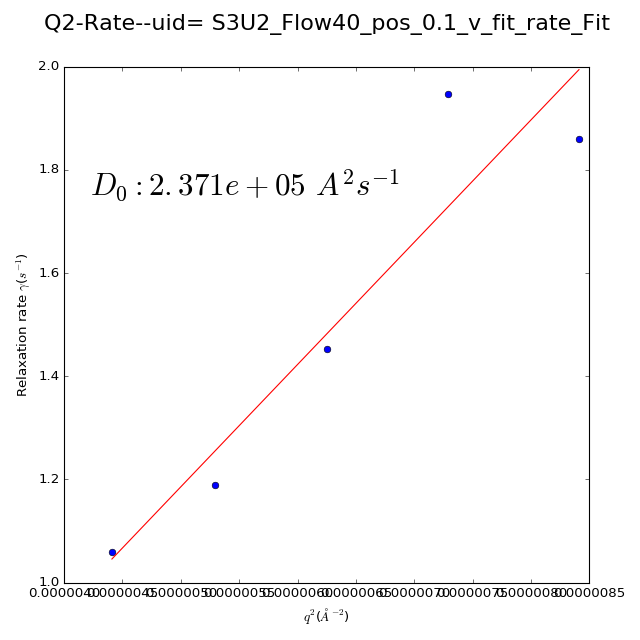

In [61]:
if fit:
    for key in list( g2s.keys()):
        for conf in ['p','v']:
            rcen = md['rcen_%s'%conf]
            acen = md['acen_%s'%conf]
            
            g2_, taus_ = g2s_average[conf][key], taus 
            res_pargs = dict(taus=taus, q_ring_center=np.unique(rcen), 
                                ang_center= np.unique(acen),  path= data_dir_, uid=uid_ +'_1a_mq%s'%conf       )
            
            save_g2( g2_, taus=taus_, qr=rcen, qz=acen, uid=uid_ +'_1a_mq%s'%conf, path= data_dir_ )            
            
            
            if conf=='v': #means perpendicular
                function = 'stretched'                            
                g2_fit_result, taus_fit, g2_fit = get_g2_fit( g2_,  res_pargs=res_pargs, 
                        function = function,  vlim=[0.95, 1.05], 
                        fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True,
                           },
                       fit_range= None,                                
                        guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01,
                         })
            else:#here is 'p', for parallel
                
                function =  'flow_para'
                g2_fit_result, taus_fit, g2_fit = get_g2_fit( g2_,  res_pargs=res_pargs, 
                    function = function,  vlim=[0.99, 1.05], fit_range= None,
                    fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True,
                          'flow_velocity':True,  },
                        guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.5,
                 'flow_velocity':5.0, } ) 

            plot_g2( g2_, res_pargs= res_pargs, tau_2 = taus_fit, g2_2 = g2_fit,  
                                        fit_res= g2_fit_result, function = function,     
                                        master_plot = 'qz',vlim=[0.95, 1.05],
                                        geometry='ang_saxs', append_name= conf +'_fit'  )

            dfv = save_g2_fit_para_tocsv(g2_fit_result, 
                                            filename= uid_ +'_1a_mq'+conf+'_fit_para', path=data_dir_ ) 
 
            fit_q_rate(  np.unique(rcen)[:],dfv['relaxation_rate'], power_variable= False, 
                                   uid=uid_ +'_'+conf+'_fit_rate', path= data_dir_ )
        

        
  

# Create a report for the avergae g2

In [62]:
create_report = True

In [63]:
#data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

In [64]:
pdf_out_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
filename= "XPCS_Flow_Analysis_Report_for_uid=%s-average.pdf"%uid_
print (pdf_out_dir + filename)

/XF11ID/analysis/2016_3/colosqui/Results/XPCS_Flow_Analysis_Report_for_uid=S3U2_Flow40_pos_0.1-average.pdf


In [65]:
if create_report:
    
    c= create_pdf_report(  data_dir_, uid_, pdf_out_dir,
                        filename= filename)
    page =1
    #Page one: Meta-data/Iq-Q/ROI
    c.report_header(page=page)
    c.report_meta( top=730)
    c.report_static( top=560)
    c.report_ROI( top= 300)
    Nk = len( list( g2s.keys()))
    Npages = Nk//2 + Nk%2
    
    for i, key in enumerate( list( g2s.keys())):        
        if not i%2:
            page += 1
            c.new_page()            
        
        c.report_header(page=page)
        if i%2:
            top = 350
        else:
            top = 720
        
        #c.report_static( top=560, iq_fit =fit_form )
        #c.report_ROI( top= 300)
    
        #c.report_one_time( top= top, g2_fit_file =  'uid=%s@run--%s--g2--fit-.png'%(uid_,key  ),                     
        #                         q_rate_file =  'uid=%s@run--%s--Q-Rate--fit-.png'%(uid_,key  ))
        
        c.new_page()
        c.report_flow_pv_g2( top= 720)   
        
    c.save_page()
    c.done()  


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/colosqui/Results/XPCS_Flow_Analysis_Report_for_uid=S3U2_Flow40_pos_0.1-average.pdf
****************************************


### Attach the whole g2 result to the last uid

In [66]:
uid_last = useful_uids[1][len(useful_uids)]

In [67]:
#uid_last  #useful_uids[key][k]
filename = c.filename  #XPCS_Analysis_Report_for_uid=%s.pdf'%uid_ 
atch=[  Attachment(open(filename, 'rb')) ] 
update_olog_uid( uid=uid_last, text='Add XPCS Analysis PDF Report', attachments= atch )

# The End!